In [1]:
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

from utils import preprocessing
from utils.constants import PLOTCOLORS, ch_cols

RANDOM_STATE = 21

cwd = Path.cwd()
husky_data = cwd / "borealtc-data"
vulpi_data = cwd / "data"
figs_path = cwd / "analysis" / "figs"
figs_path.mkdir(parents=True, exist_ok=True)

# COLORS = {
#     "base": PLOTCOLORS["dirt road"],
#     "ours": PLOTCOLORS["concrete"],
# }

In [2]:
# Define channels
columns = {
    "imu": {
        "wx": True,
        "wy": True,
        "wz": True,
        "ax": True,
        "ay": True,
        "az": True,
    },
    "pro": {
        "velL": True,
        "velR": True,
        "curL": True,
        "curR": True,
    },
}
summary = pd.DataFrame({"columns": pd.Series(columns)})

In [3]:
husky_summ = summary.copy()
vulpi_summ = summary.copy()

husky_dfs = preprocessing.get_recordings(husky_data, husky_summ)
vulpi_dfs = preprocessing.get_recordings(vulpi_data, vulpi_summ)

husky_pro = husky_dfs["pro"].copy()
vulpi_pro = vulpi_dfs["pro"].copy()

In [4]:
# Set data partition parameters
N_FOLDS = 5
PART_WINDOW = 5  # seconds

# Data partition and sample extraction
train, test = preprocessing.partition_data(
    husky_dfs,
    husky_summ,
    PART_WINDOW,
    N_FOLDS,
    random_state=RANDOM_STATE,
)

In [15]:
train_imu = train[0]["imu"]
train_pro = train[0]["pro"]
imu_parts = train_imu[[0, 1000], :, :]
pro_parts = train_pro[[0, 1000], :, :]
imu_data = imu_parts[:, :, ch_cols["time"] :]
pro_data = pro_parts[:, :, ch_cols["time"] :]

imu_data[1, :, 0] = imu_data[1, :, 0] - imu_data[1, 0, 0] + 5
pro_data[1, :, 0] = pro_data[1, :, 0] - pro_data[1, 0, 0] + 5
# imu_data[1, :, 0] = imu_data[1, :, 0] - imu_data[1, 0, 0] + imu_data[0, -1, 0]
# pro_data[1, :, 0] = pro_data[1, :, 0] - pro_data[1, 0, 0] + pro_data[0, -1, 0]
terrains = imu_parts[:, 0, ch_cols["terrain"]].tolist()
labels = [terr.replace("_", " ").title() for terr in terrains]

In [28]:
husky_dfs["imu"].columns.values, husky_dfs["pro"].columns.values

(array(['time', 'wx', 'wy', 'wz', 'ax', 'ay', 'az', 'terrain', 'run_idx'],
       dtype=object),
 array(['time', 'velL', 'velR', 'curL', 'curR', 'terrain', 'run_idx'],
       dtype=object))

/tmp/ipykernel_2235979/1608969558.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


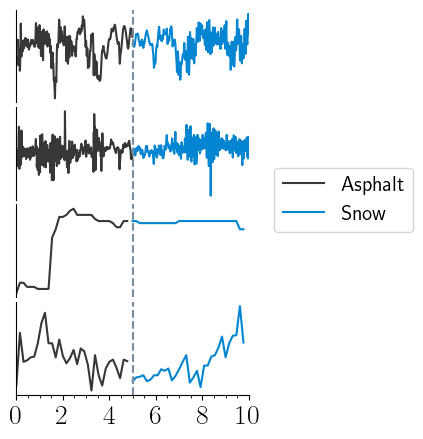

In [35]:
with plt.style.context("analysis/figure.mplstyle"):
    fig, axs = plt.subplots(nrows=4, gridspec_kw={"hspace": 0.05}, figsize=(3, 5))
    for idx, lab in enumerate(labels):
        axs[0].plot(
            imu_data[idx, :, 0],
            imu_data[idx, :, 1],
            color=PLOTCOLORS[lab.lower()],
            label=lab,
        )
        axs[1].plot(
            imu_data[idx, :, 0],
            imu_data[idx, :, 4],
            color=PLOTCOLORS[lab.lower()],
            # label=lab,
        )
        axs[2].plot(
            pro_data[idx, :, 0],
            pro_data[idx, :, 1],
            color=PLOTCOLORS[lab.lower()],
            # label=lab,
        )
        axs[3].plot(
            pro_data[idx, :, 0],
            pro_data[idx, :, 3],
            color=PLOTCOLORS[lab.lower()],
            # label=lab,
        )
    fig.legend(loc="center left", bbox_to_anchor=(0.95, 0.5))
    # axs[-1].set_xlabel("Time (s)")

    # axs[0].set_ylabel("$\\omega_x$ $(rad/s)$", rotation=0, ha="right", va="center")
    # axs[1].set_ylabel("$a_x$ $(m/s^2)$", rotation=0, ha="right", va="center")
    # axs[2].set_ylabel("$v_L$ $(m/s)$", rotation=0, ha="right", va="center")
    # axs[3].set_ylabel("$I_L$ $(A)$", rotation=0, ha="right", va="center")

    for idx, ax in enumerate(axs):
        ax.set_xlim(left=0, right=10)
        ax.spines[["right", "top"]].set_visible(False)
        ax.yaxis.set_label_coords(-0.05, 0.5)
        ax.set_yticks([])
        if ax == axs[-1]:
            ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
        else:
            ax.set_xticks([])
            ax.spines[["bottom"]].set_visible(False)

        ax.axvline(x=5, color="xkcd:blue/grey", linestyle="--")

    fig.tight_layout()
    fig.savefig(figs_path / "signals.pdf", bbox_inches="tight")